In [1]:
import torch
import torch_geometric
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm
import numpy as np
local = False

# Load Dataset

In [2]:
import json
PATH = "/Users/dagm/desktop/cog-rob-multi-agent-prediction-project/data/"
data_train = {}
with open(PATH + "data_siren_training.json") as json_file:
    data_train = json.load(json_file)

data_test = {}
with open(PATH + "data_siren_test.json") as json_file:
    data_test = json.load(json_file)

# Parse Dataset into Tensors

In [3]:
import math
from itertools import combinations
from itertools import permutations
from torch_geometric.data import Data

def encode_label(label):
  temp = ["IGNORING", "GOING", "YIELDING"]
  encode = [0] * 3
  encode[temp.index(label)] = 1
  return encode

def generate_node_feature_tensor(data_window):
    """
    Transform the simulated data into a node tensor encoding five previous 
    timesteps and features are x, y, v_x, and v_y for every given node in out
    system

    Input: 
      generated_data - a list of state dictionaries  for every vehicle in the
                       the graph
    Output: A PyTorch tensor with dimensioanlity (#Node, 5, 4)
    """

    time_window = len(data_window)
    agent_count = len(data_window[0]["agents"])
    node_feature_tensor = torch.zeros((agent_count, time_window, 4))
    node_type_tensor = torch.zeros((agent_count,1))
    for node_idx in range(agent_count):
      node_type_tensor[node_idx,0] = data_window[0]["agents"][node_idx]["type"]
      for time in range(time_window):
        node_feature_tensor[node_idx][time][0] = data_window[time]["agents"][node_idx]["state"][0]
        node_feature_tensor[node_idx][time][1] = data_window[time]["agents"][node_idx]["state"][1]
        node_feature_tensor[node_idx][time][2] = data_window[time]["agents"][node_idx]["state"][2]
        node_feature_tensor[node_idx][time][3] = data_window[time]["agents"][node_idx]["state"][3]
    
    return node_feature_tensor, node_type_tensor

def generate_edge_feature_tensor(data,label_data):
    """
    Transform the simulated data into a node tensor encoding five previous 
    timesteps and features are x, y, v_x, and v_y for every given node in out
    system

    Input: 
      generated_data - a list of state dictionaries  for every vehicle in the
                       the graph
    Output: A PyTorch tensor with dimensioanlity (#Node, 5, 4)
    """

    agent_count = len(data)
    edge_feature_tensor = torch.zeros((math.factorial(agent_count),4))
    edge_list = torch.zeros((math.factorial(agent_count),2))
    labels = []

    combination_agents = permutations(data,2)
    for i, agent_pair in enumerate(combination_agents):
      from_node, to_node = agent_pair
      from_node_id, to_node_id = from_node["agent_id"], to_node["agent_id"]
      edge_list[i][0] = from_node_id
      edge_list[i][1] = to_node_id
      labels.append(encode_label(label_data[from_node_id][to_node_id]))

      edge_feature_tensor[i][0] = from_node["state"][0] - to_node["state"][0]
      edge_feature_tensor[i][1] = from_node["state"][1] - to_node["state"][1]
      edge_feature_tensor[i][2] = from_node["state"][2] - to_node["state"][2]
      edge_feature_tensor[i][3] = from_node["state"][3] - to_node["state"][3]
    
    labels = torch.tensor(labels)
    return edge_feature_tensor, edge_list, labels


def sequence_node_data(data):
    node_data = []
    type_data = []
    for t in range(200,len(data)):
      data_window = [data[t-200], data[t-150], data[t-100], data[t-50], data[t]]
      feature_tensor, type_tensor = generate_node_feature_tensor(data_window)
      node_data.append(feature_tensor)
      type_data.append(type_tensor)
    return node_data, type_data

def sequence_edge_data(data):
    edge_data = []
    edge_list_data = []
    labels = []
    for time in data:
      tensor,edge_list,label = generate_edge_feature_tensor(time["agents"],time["labels"])
      edge_data.append(tensor)
      edge_list_data.append(edge_list)
      labels.append(label)
    # print(len(labels), labels[0].shape)
    return edge_data,edge_list_data,labels

def create_joined_data_array(all_data):
    joined_data = []
    TYPE_TENSOR = None
    for data in all_data["data"]:
        edge_features_data_list,edges,edge_labels = sequence_edge_data(data)
        edge_labels = edge_labels[200:]
        edge_features_data_list = edge_features_data_list[200:]
        node_features_data_list, type_tensor = sequence_node_data(data)
        for i in range(len(edge_features_data_list)):
            data_point = Data(x=node_features_data_list[i], edge_index=edges[0], edge_attr=edge_features_data_list[i],pos=type_tensor[i],y=edge_labels[i])
            joined_data.append(data_point)
    return joined_data

In [4]:
train_data = create_joined_data_array(data_train)
test_data = create_joined_data_array(data_test)

In [5]:
from torch_geometric.data import DataLoader
loader = DataLoader(train_data)

/Users/dagm/.local/share/virtualenvs/cog-rob-multi-agent-prediction-project-g7NkvVIu/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Define Model

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer

inputs = 128
hidden = 128
outputs = 3

class PastStateEncoder(nn.Module):
    def __init__(self, output_size, timesteps, features):
      super().__init__()
      self.output_size = output_size
      self.embedding = nn.Embedding(timesteps, features)
      self.conv = nn.Conv1d(features*2,output_size,3,1,1)

    def forward(self, x):
      B, L, H = x.shape
      pos = torch.arange(L).to(device)
      x = torch.cat([x, self.embedding(pos).view(1, L, 4).expand(B, L, 4)], dim=-1)
      x = x.transpose(2,1)
      return self.conv(x).mean(dim=-1)

class FusionLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.fuse = nn.Linear(129 , 128)

    def forward(self, x):
      return self.fuse(x)

class EdgeModel(torch.nn.Module):
    def __init__(self,num_features_in,edge_features_in, hidden):
        super().__init__()
        self.edge_mlp = nn.Sequential(nn.Linear(2 * num_features_in + edge_features_in , hidden),
                       nn.ReLU(),
                       nn.Linear(hidden, 128))

    def forward(self, src, dest, edge_attr, u, batch):
        # src, dest: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        # print(src.shape, "THIS IS SRC")
        # print(dest.shape, "THIS IS dest")
        # print(edge_attr.shape, "THIS IS edge_attr")
        out = torch.cat([src, dest, edge_attr], 1)
        out = self.edge_mlp(out)
        return out

class NodeModel(torch.nn.Module):
    def __init__(self,num_features_in, edge_features_in, hidden):
        super().__init__()
        self.node_mlp_1 = nn.Sequential(nn.Linear(2*num_features_in, hidden),        
                       nn.ReLU(),
                       nn.Linear(hidden, 128))

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        return self.node_mlp_1(out) 
    

def make_meta(num_features_in,edge_features_in,hidden):
  return MetaLayer(edge_model=EdgeModel(num_features_in,edge_features_in,hidden), 
                   node_model=NodeModel(num_features_in,edge_features_in, hidden))

class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(GraphNeuralNetwork, self).__init__()
        self.final_mlp = Seq(Lin(hidden, hidden), 
                            BatchNorm1d(hidden),
                            ReLU(),
                            Lin(hidden, outputs))
        self.rnn = PastStateEncoder(128, 5, 4)
        self.fuse = FusionLayer()
        self.gnn1 = make_meta(128,4,128)
        self.gnn2 = make_meta(128,128,128)
        
    def forward(self, x, edge_index, edge_attr, batch, node_type):
        x = self.rnn(x)
        x = torch.cat([x,node_type], dim=-1)
        x = self.fuse(x)
        x, edge_attr, u = self.gnn1(x, edge_index, edge_attr, None, batch)
        x, edge_attr, u = self.gnn2(x, edge_index, edge_attr, None, batch)
        out = self.final_mlp(edge_attr)
        return out
    
model = GraphNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)

# Setup Training

In [19]:
LOSS_WEIGHT_1 = torch.tensor([0.042, 1.0, 1.0])
LOSS_WEIGHT_2 = torch.tensor([0.0363, 1.0, 1.0])

@torch.no_grad()
def test(model, loader, total, batch_size, leave=False):
    model.eval()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader), total=total/batch_size, leave=leave)
    for i, data in t:
        data = data.to(device)
        y = torch.argmax(data.y, dim=1)
        batch_output = model(data.x, data.edge_index.type(torch.LongTensor).to(device), data.edge_attr, data.batch, data.pos)
        batch_loss_item = xentropy(batch_output, y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size, leave=False):
    model.train()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader), total=total/batch_size, leave=leave)
    for i, data in t:
        data = data.to(device)
        y = torch.argmax(data.y, dim=1)
        optimizer.zero_grad()
        batch_output = model(data.x, data.edge_index.type(torch.LongTensor).to(device), data.edge_attr, data.batch, data.pos)
        batch_loss = xentropy(batch_output, y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

# Define training, validation, testing dataloaders

In [20]:
from torch_geometric.data import Data, DataListLoader, Batch
from torch.utils.data import random_split

def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)

torch.manual_seed(0)
valid_frac = 0.20
full_length = len(train_data)
valid_num = int(valid_frac*full_length)
batch_size = 64

train_dataset, valid_dataset = random_split(train_data, [full_length-valid_num,valid_num])

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, pin_memory=True, shuffle=False)


train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_data)

/Users/dagm/.local/share/virtualenvs/cog-rob-multi-agent-prediction-project-g7NkvVIu/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Train

In [21]:
import os.path as osp

n_epochs = 40
stale_epochs = 0
best_valid_loss = 99999
patience = 20
t = tqdm(range(0, n_epochs))

for epoch in t:
    loss = train(model, optimizer, train_loader, train_samples, batch_size, leave=bool(epoch==n_epochs-1))
    valid_loss = test(model, valid_loader, valid_samples, batch_size, leave=bool(epoch==n_epochs-1))
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('           Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('interactionnetwork_best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 00, Training Loss:   0.2695
           Validation Loss: 0.1959
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 01, Training Loss:   0.2085
           Validation Loss: 0.1950
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 02, Training Loss:   0.1950
           Validation Loss: 0.2576
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 03, Training Loss:   0.1879
           Validation Loss: 0.1852
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 04, Training Loss:   0.1806
           Validation Loss: 0.1567
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 05, Training Loss:   0.1699
           Validation Loss: 0.1501
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 06, Training Loss:   0.1624
           Validation Loss: 0.1261
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 07, Training Loss:   0.1520
           Validation Loss: 0.1595
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 08, Training Loss:   0.1530
           Validation Loss: 0.1494
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 09, Training Loss:   0.1412
           Validation Loss: 0.1192
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 10, Training Loss:   0.1360
           Validation Loss: 0.1734
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 11, Training Loss:   0.1378
           Validation Loss: 0.1066
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 12, Training Loss:   0.1317
           Validation Loss: 0.1451
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 13, Training Loss:   0.1208
           Validation Loss: 0.1649
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 14, Training Loss:   0.1358
           Validation Loss: 0.1201
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 15, Training Loss:   0.1297
           Validation Loss: 0.1048
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 16, Training Loss:   0.1276
           Validation Loss: 0.0959
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 17, Training Loss:   0.1148
           Validation Loss: 0.0870
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 18, Training Loss:   0.1167
           Validation Loss: 0.1138
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 19, Training Loss:   0.1150
           Validation Loss: 0.0965
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 20, Training Loss:   0.1120
           Validation Loss: 0.1517
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 21, Training Loss:   0.1152
           Validation Loss: 0.1309
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 22, Training Loss:   0.1198
           Validation Loss: 0.1530
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 23, Training Loss:   0.1156
           Validation Loss: 0.0968
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 24, Training Loss:   0.1136
           Validation Loss: 0.1205
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 25, Training Loss:   0.1145
           Validation Loss: 0.1808
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 26, Training Loss:   0.1140
           Validation Loss: 0.1082
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 27, Training Loss:   0.1080
           Validation Loss: 0.0779
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 28, Training Loss:   0.1092
           Validation Loss: 0.1016
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 29, Training Loss:   0.1114
           Validation Loss: 0.2444
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 30, Training Loss:   0.1112
           Validation Loss: 0.1996
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 31, Training Loss:   0.1070
           Validation Loss: 0.0844
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 32, Training Loss:   0.1126
           Validation Loss: 0.1027
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 33, Training Loss:   0.1114
           Validation Loss: 0.0996
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 34, Training Loss:   0.1113
           Validation Loss: 0.1174
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 35, Training Loss:   0.1128
           Validation Loss: 0.0847
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 36, Training Loss:   0.1042
           Validation Loss: 0.0894
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 37, Training Loss:   0.1045
           Validation Loss: 0.1396
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 38, Training Loss:   0.1083
           Validation Loss: 0.1099
Stale epoch


  0%|          | 0/534.953125 [00:00<?, ?it/s]

  0%|          | 0/133.734375 [00:00<?, ?it/s]

Epoch: 39, Training Loss:   0.1102
           Validation Loss: 0.0991
Stale epoch


# Evaluate

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

model.eval()
t = tqdm(enumerate(test_loader),total=test_samples/batch_size)
y_test = []
y_predict = []
for i,data in t:
    data = data.to(device)    
    batch_output = model(data.x, data.edge_index.type(torch.LongTensor).to(device), data.edge_attr, data.batch, data.pos)
    y_predict.append(batch_output.detach().cpu().numpy())
    y_test.append(data.y.cpu().numpy())
y_test = np.concatenate(y_test)
y_predict = np.concatenate(y_predict)

  0%|          | 0/313.375 [00:00<?, ?it/s]

## Top 1 Accuracy

In [23]:
y_predict_bool = (y_predict > 0.5) 
y_test_bool = (y_test > 0.5)
print(accuracy_score(y_predict_bool,y_test_bool), "ACCURACY")

0.8532857997606701 ACCURACY


## Confusion Matrix

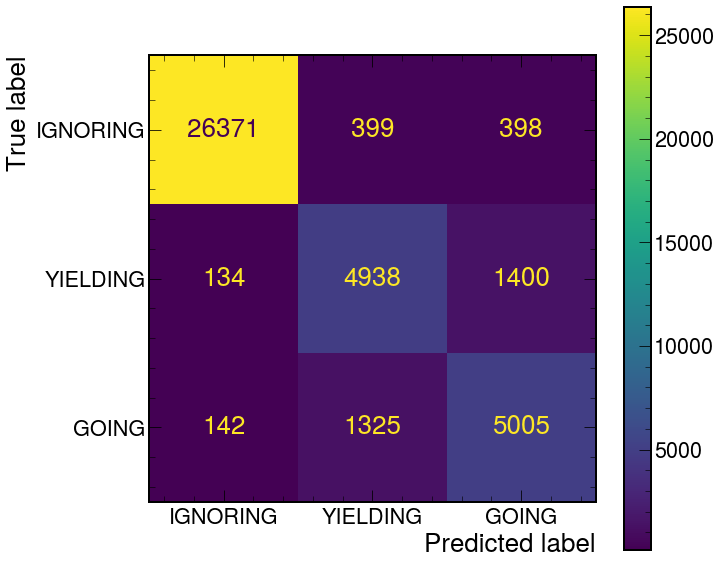

In [24]:
from matplotlib import pyplot as plt
y_test_non_category = [ np.argmax(t) for t in y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_predict ]
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["IGNORING", "YIELDING", "GOING"])
disp.plot()
plt.show()

## ROC-AUC Curve

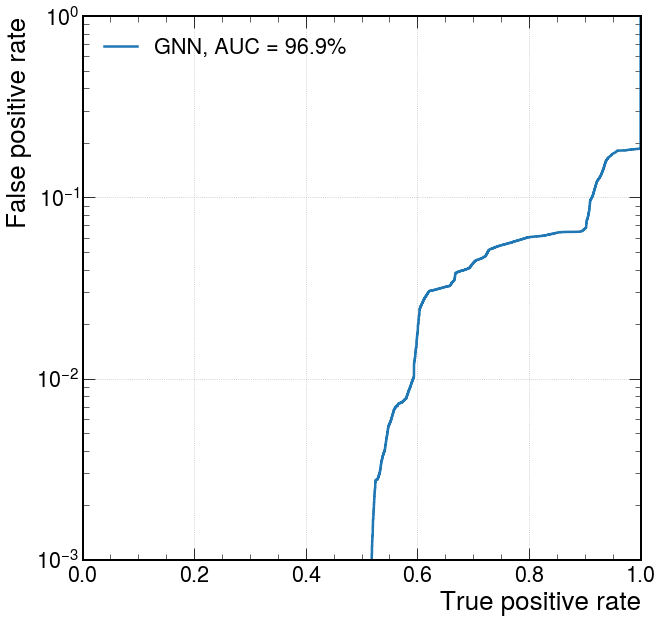

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test[:,1], y_predict[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()